<a href="https://colab.research.google.com/github/AnnaVitali/plantRecognition/blob/develop/plantRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download training set

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Saving kaggle.json to kaggle.json
ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                        480KB  2023-01-04 12:50:31           4860        174  1.0              
senapatirajesh/netflix-tv-shows-and-movies                      Latest Netflix TV shows and movies                  1MB  2023-01-14 17:03:12           1372         38  0.9411765        
johnny1994/divorce-rates-data-should-you-get-married            Divorce Rates Data: Should You Get Married?        22KB  2023-01-15 12:49:06            802         31  0.88235295       
rakkesharv/spotify-top-10000-streame

In [2]:
! unzip new-plant-diseases-dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New P

## Import

In [11]:
import os
import glob
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import interact, fixed
import ipywidgets as widgets

## Utilities

In [4]:
class_names = ['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']

def load_data(data_folder_path):
    image_list=[]
    label_list=[]
    class_folder_path_list=glob.glob(data_folder_path+'/*/')
    for class_folder_path in class_folder_path_list:
        class_folder_path=class_folder_path.replace('\\','/')
        folder_label=os.path.basename(class_folder_path.split("_")[0])

        for image_file_path in glob.glob(class_folder_path+'/*'):
            image_file_path=image_file_path.replace('\\','/')
            image=Image.open(image_file_path)
            image = np.asarray(image)[:,:,:3]
            image = cv2.resize(image, (64, 64), interpolation = cv2.INTER_LINEAR)
            image_list.append(image)
            label_list.append(class_names.index(folder_label))

    return np.asarray(image_list),np.asarray(label_list)


def show_images(index, images):
  rows = 5
  columns = 10
  plt.rcParams.update({'font.size': 20})
  _, axs = plt.subplots(rows, columns, squeeze=False, figsize=(20, 10))

  for i in range(rows*columns):
    r = i // columns
    c = i % columns
    axs[r, c].axis('off')
    axs[r, c].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axs[r, c].set_title(class_names[train_y[index[i]]], fontsize = 16)


## Caricamento dataset

In [5]:
db_path_train = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
db_path_valid = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

train_x, train_y = load_data(db_path_train)
valid_x, valid_y = load_data(db_path_valid)


print('Shape training set: {}'.format(train_x.shape))
print('Shape validation set: {}'.format(valid_x.shape))

Shape training set: (70295, 64, 64, 3)
Shape validation set: (17572, 64, 64, 3)


## Visualizzazione immagini

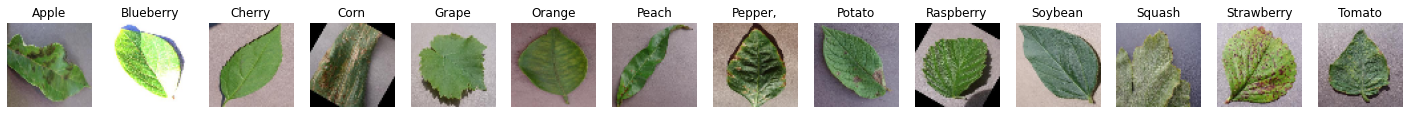

In [6]:
_, axs = plt.subplots(1, len(class_names),figsize=(25, 25))
for i in range(len(class_names)):
  train_class_pos=np.where(train_y==i)
  rnd_idx=random.randint(0,len(train_class_pos[0]))
  p=train_class_pos[0][rnd_idx]
  axs[i].imshow(train_x[p]),axs[i].axis('off'),axs[i].set_title(class_names[train_y[p]])

## Estrazione delle feature

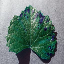

Grape


In [27]:
image_to_retrieve = 50
i = random.randint(0,len(valid_x))
query = valid_x[i]

cv2_imshow(query)
print(class_names[valid_y[i]])

### Feature di forma

In [28]:
w_h_range=widgets.IntRangeSlider(description='Range H:',min=0,max=255,value=(0,255), step=1,continuous_update=False)
w_s_range=widgets.IntRangeSlider(description='Range S:',min=0,max=255,value=(0,255), step=1,continuous_update=False)
w_v_range=widgets.IntRangeSlider(description='Range V:',min=0,max=255,value=(0,255), step=1,continuous_update=False)

hsv = cv2.cvtColor(query,cv2.COLOR_BGR2HSV)
@interact(hsv=fixed(hsv),h_range=w_h_range,s_range=w_s_range,v_range=w_v_range)
def interactive_masked_roi(hsv, h_range,s_range,v_range):
  mask = cv2.inRange(hsv, (h_range[0],s_range[0],v_range[0]), (h_range[1],s_range[1],v_range[1]))
  cv2_imshow(mask)

interactive(children=(IntRangeSlider(value=(0, 255), continuous_update=False, description='Range H:', max=255)…

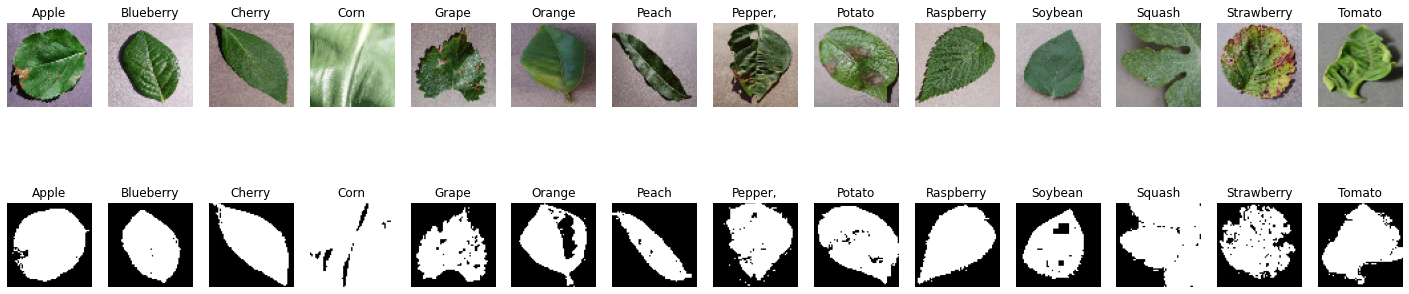

In [59]:
alpha = 1.5
beta = 2
_, axs = plt.subplots(2, len(class_names),figsize=(25, 25))
plt.subplots_adjust(bottom=0.5, top=0.7, hspace=0)
for i in range(len(class_names)):
  train_class_pos=np.where(train_y==i)
  rnd_idx=random.randint(0,len(train_class_pos[0]))
  p=train_class_pos[0][rnd_idx]
  img = train_x[p]

  
  # convert to hsv
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  # threshold using inRange
  h_min_value=49  #w_h_range.value[0]
  h_max_value=104 #w_h_range.value[1]
  s_min_value=19 #w_s_range.value[0]
  s_max_value=255 #w_s_range.value[1]
  v_min_value=0 #w_v_range.value[0]
  v_max_value=255 #w_v_range.value[1]

  lower_bound = np.array([h_min_value, s_min_value, v_min_value])
  upper_bound = np.array([h_max_value, s_max_value, v_max_value])

  mask = cv2.inRange(hsv,lower_bound,upper_bound)
  sm = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((1,1), np.uint8))
 
  axs[0,i].imshow(img, cmap='gray'),axs[0, i].axis('off'),axs[0, i].set_title(class_names[train_y[p]])
  axs[1,i].imshow(sm, cmap='gray'),axs[1, i].axis('off'),axs[1, i].set_title(class_names[train_y[p]])

In [8]:
from tensorflow.python.ops.gen_data_flow_ops import barrier_close_eager_fallback
def compute_shape_features(img):
  gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, 3)
  gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, 3)
  gmod = cv2.convertScaleAbs(np.sqrt(pow(gx, 2) * pow(gy, 2)))
  imgResize = cv2.resize(gmod, (30,20), cv2.THRESH_BINARY)
  _,imgBin = cv2.threshold(imgResize, 200, 255, cv2.THRESH_BINARY) 
  sm = cv2.morphologyEx(imgBin, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
  return sm.flatten()

def compute_shape_feature_similarities(f1, f2):
  return np.minimum(f1, f2).sum() / np.maximum(f1, f2).sum()

def compute_shape_ranking(db_features, query_feature_vector):
  similarities =[compute_shape_feature_similarities(db_feature_vector, query_feature_vector) for db_feature_vector in db_features]
  sorted_idx = np.array(similarities).argsort()[::-1]
  return sorted_idx

def show_images(index, images):
  rows = 4
  columns = 5
  plt.rcParams.update({'font.size': 20})
  _, axs = plt.subplots(rows, columns, squeeze=False, figsize=(30, 15))

  for i in range(rows*columns):
    r = i // columns
    c = i % columns
    axs[r, c].axis('off')
    axs[r, c].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axs[r, c].set_title(train_x[index[i]][1])

train_gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_x]
train_shape_features = [compute_shape_features(img) for img in tqdm(train_gray_images)]


  0%|          | 0/70295 [00:00<?, ?it/s]

#### Risulati feature di forma

In [ ]:
query_shape_features = compute_shape_features(cv2.cvtColor(query, cv2.COLOR_BGR2GRAY))
shape_ranking = compute_shape_ranking(train_shape_features, query_shape_features)
shape_result = [train_x[i] for i in shape_ranking]

In [ ]:
cv2_imshow(query)
print(" ")
show_images(shape_ranking, shape_result[:image_to_retrieve])